In [1]:
import psycopg2
import config as creds
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

### Connecting to the Database

In [2]:
user=creds.PGUSER
password=creds.PGPASSWORD
host=creds.PGHOST
port=5432
database=creds.PGDATABASE

In [3]:
engine_str=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"

In [4]:
engine = create_engine(engine_str)

In [73]:
conn = engine.raw_connection()
print('Connected')

Connected


In [74]:
cur = conn.cursor()
print('Cursor created')

Cursor created


### Checking to see what data is hosted inside the database

In [7]:
query1='''
SELECT * 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH; 
'''

In [8]:
df1=pd.read_sql(query1,conn)

In [9]:
pd.set_option('display.max_columns',None)

In [10]:
df1.head()

,id,pid,dcrealpropertyid,ward,postalcode,yearbuilt,reportingyear,reportstatus,primarypropertytype_selfselect,taxrecordfloorarea,reportedbuildinggrossfloorarea,energystarscore,month,kbtu,elegas,id,date,awnd,cldd,htdd,snow,tavg,tmax,tmin,wdf2,wdf5,wsf2,wsf5,weatheryear,month
0,0,PM4373175,0171_0814,2,20006,1893,2016,In Compliance,2,137024.0,176170.0,0.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1
1,3,PM1331555,0248_0812,2,20005,1921,2016,In Compliance,7,146425.0,222000.0,52.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1
2,4,PM3299991,0139_0817,2,20036,1963,2016,In Compliance,10,101337.0,73168.0,38.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1
3,5,PM4357992,0494_0860,6,20024,1968,2016,In Compliance,10,80612.0,60000.0,87.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1
4,6,PM3632510,0182_0083,2,20036,2001,2016,In Compliance,2,184556.0,158819.0,49.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1


In [11]:
df1['kbtusqft']=df1['kbtu']/df1['taxrecordfloorarea']

In [75]:
query2='''
SELECT b.kbtu,b.taxrecordfloorarea, b.ward, b.primarypropertytype_selfselect, b.elegas, n.awnd,
       n.cldd, n.htdd, n.tavg, n.wdf2, n.wdf5, n.wsf2,n.wsf5, n.date 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH
AND b.KBTU > 0
AND b.WARD >= 6; 
'''

In [76]:
df2=pd.read_sql(query2, conn)

In [70]:
conn.close()
print('Closed')

Closed


In [77]:
df2['kbtusqft']=df2['kbtu']/df2['taxrecordfloorarea']

In [78]:
df2['datetime']=pd.to_datetime(df2['date'])

In [79]:
df2['primarypropertytype_selfselect']=df2['primarypropertytype_selfselect'].astype('object')

In [80]:
df2.head()

,kbtu,taxrecordfloorarea,ward,primarypropertytype_selfselect,elegas,awnd,cldd,htdd,tavg,wdf2,wdf5,wsf2,wsf5,date,kbtusqft,datetime
0,2949500.0,256738.0,6,10,N,9.8,0.0,906.0,35.8,300.0,310.0,36.0,49.0,2018-01,11.488366,2018-01-01
1,463.4,100794.0,6,7,N,9.8,0.0,906.0,35.8,300.0,310.0,36.0,49.0,2018-01,0.004597,2018-01-01
2,866589.5,77767.0,7,7,N,9.8,0.0,906.0,35.8,300.0,310.0,36.0,49.0,2018-01,11.143409,2018-01-01
3,4459085.0,258654.0,6,7,N,9.8,0.0,906.0,35.8,300.0,310.0,36.0,49.0,2018-01,17.239575,2018-01-01
4,1715341.7,69502.0,8,6,N,9.8,0.0,906.0,35.8,300.0,310.0,36.0,49.0,2018-01,24.680465,2018-01-01


In [81]:
df2.columns

Index(['kbtu', 'taxrecordfloorarea', 'ward', 'primarypropertytype_selfselect',
       'elegas', 'awnd', 'cldd', 'htdd', 'tavg', 'wdf2', 'wdf5', 'wsf2',
       'wsf5', 'date', 'kbtusqft', 'datetime'],
      dtype='object')

In [82]:
df2.dtypes

kbtu                                     float64
taxrecordfloorarea                       float64
ward                                       int64
primarypropertytype_selfselect            object
elegas                                    object
awnd                                     float64
cldd                                     float64
htdd                                     float64
tavg                                     float64
wdf2                                     float64
wdf5                                     float64
wsf2                                     float64
wsf5                                     float64
date                                      object
kbtusqft                                 float64
datetime                          datetime64[ns]
dtype: object

In [99]:
df2=df2[['ward', 'primarypropertytype_selfselect', 'elegas','awnd', 'cldd',
         'htdd', 'tavg','wdf2', 'wdf5', 'wsf2','wsf5', 'datetime','kbtusqft']]

In [100]:
df2.columns

Index(['ward', 'primarypropertytype_selfselect', 'elegas', 'awnd', 'cldd',
       'htdd', 'tavg', 'wdf2', 'wdf5', 'wsf2', 'wsf5', 'datetime', 'kbtusqft'],
      dtype='object')

In [101]:
df2.primarypropertytype_selfselect.unique()

array(['10', '7', '6', '2', '15', '19', '3', '4', '11', '17', '13', '16',
       '9', '18', '5'], dtype=object)

In [160]:
from sklearn.model_selection import train_test_split as tts

TARGET = ['kbtusqft']
COLS =['ward', 'primarypropertytype_selfselect', 'elegas','awnd',
       'cldd', 'htdd', 'tavg','wdf2', 'wdf5', 'wsf2','wsf5', 'datetime']

def make_sklearn_data(df=df2, target=TARGET, cols=COLS):
    # Add the datetime column back to the main dataframe
    df = df.reset_index()
    X, y = df[cols], df[target]
    X.to_numpy()
    y.to_numpy()
    return X, y
# def make_sklearn_data(df=df2, splits=True, train_size=0.8, target=TARGET, cols=COLS):
#     # Add the datetime column back to the main dataframe
#     df = df.reset_index()
#     X, y = df[cols], df[target]
    
#     if splits:
#         return tts(X, y, train_size=train_size)
#     return X, y

<AxesSubplot:xlabel='datetime_cos', ylabel='datetime_sin'>

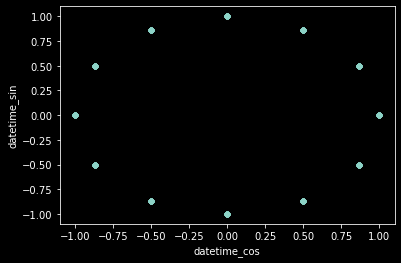

In [161]:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="month"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "month":
            return x.dt.month
        elif self.date_extract == "year":
            return x.dt.year
        else:
            raise NotImplementedError(f"{self.date_extract} date component not implemented yet")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(df2.reset_index()["datetime"])
ce.plot(x="datetime_cos", y="datetime_sin", kind="scatter")

### Construct a Pipeline

In [162]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

Create multiple pipelines

In [163]:
numeric_transform = Pipeline(steps=[('scaler', StandardScaler())])
category_transform = Pipeline(steps=[
    ('ward', OneHotEncoder(handle_unknown='ignore')),
    ('energy_type', OneHotEncoder(handle_unknown='ignore'))
    ])
time_transform = Pipeline(steps=[
    ('time_components', FeatureUnion([
            ('month', CyclicEncoder(date_extract='month')), 
            ('year', CyclicEncoder(date_extract='year')), 
        ]),)
])

Create Feature Search

In [164]:
# numeric_ft = df2.select_dtypes(include=['int64','float64']).columns
# category_ft = df2.select_dtypes(include=['object']).columns
# time_ft = df2.select_dtypes(include=['datetime']).columns

In [165]:
numeric_ft ='awnd', 'cldd','htdd', 'tavg','wdf2', 'wdf5', 'wsf2','wsf5'
category_ft = 'ward', 'primarypropertytype_selfselect', 'elegas'
time_ft = 'datetime'

Create Pre-Processing Pipeline

In [166]:
preprocessor = ColumnTransformer(
    transformers=[
    ('num',numeric_transform, numeric_ft ),
    ('cat',category_transform, category_ft ),
    ('time',time_transform, time_ft ),
], remainder='passthrough', sparse_threshold=0)

Create a singular pipeline

In [167]:
# engineering=Pipeline([
#     ('column_selection', ColumnTransformer([
#         #('scalar',StandardScaler()),
#         ('time_components', FeatureUnion([
#             ('month', CyclicEncoder(date_extract='month')), 
#             ('year', CyclicEncoder(date_extract='year')), 
#         ]),'datetime'),
#         #('scalar',StandardScaler()),
#         ('ward', OneHotEncoder(handle_unknown='ignore'), ['ward']),
#         ('energy_type', OneHotEncoder(handle_unknown='ignore'), ['elegas']),
#         ('scalar',StandardScaler())
#     ], remainder='passthrough')),
# ])



In [168]:
#Borrowing code from Dr.Bengfort's traffic notebook
from sklearn.base import clone
def make_energy_pipeline(model, append_transformers=None, fe=preprocessor):
        # clone the pipeline to ensure it's not fitted
    pipe = clone(fe)
    
    print(append_transformers)
    # append any steps to the pipeline
#     if append_transformers!= None:
#         for step in append_transformers:
#             pipe.steps.append(step)
    
#     pipe.steps.append(["model", clone(model)])
    return pipe

In [169]:
from functools import partial
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rmse = partial(mean_squared_error, squared=False)


def time_series_evaluate(model, X, y):
    """
    Performs time series cross validation on the model, returning the
    cross validated r2, mse, and mae of the regressor, along with the 
    final fitted model, fitted on all of the data.
    """
    cv = TimeSeriesSplit(12)
    scores = {}
    
    scores["r2"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(r2_score))
    scores["mse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_squared_error))
#     scores["rmse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(rmse))
    scores["mae"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
    
    model.fit(X, y)
    return model, scores

In [170]:
from sklearn.linear_model import LinearRegression
X, y= make_sklearn_data()
lm = make_energy_pipeline(LinearRegression())
time_series_evaluate(lm, X, y)

None


/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [155]:
from sklearn.ensemble import RandomForestRegressor
X, y= make_sklearn_data()
lm = make_energy_pipeline(RandomForestRegressor())
time_series_evaluate(lm, X, y)

None


/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [156]:
from sklearn.svm import LinearSVC
X, y= make_sklearn_data()
lm = make_energy_pipeline(LinearSVC())
time_series_evaluate(lm, X, y)

None


/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 494, in fit
    self.fit_transform(X, y=y)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py", line 531, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "/home/lioness098/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/compose/_column_trans

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [1]:
conn.close()
print('Closed')

NameError: name 'conn' is not defined